# Investigation of the Kipf and Welling Propagation Rule
Read below sources for context.
 - Blog post by Kipf: https://tkipf.github.io/graph-convolutional-networks/
 - Paper on arXiv: https://arxiv.org/pdf/1609.02907.pdf

In [1]:
from pprint import pprint
import numpy as np
from scipy.linalg import fractional_matrix_power

def power(matrix, fraction):
    return np.matrix(fractional_matrix_power(matrix, fraction))

In [2]:
A = np.matrix([
    [0, 1, 0, 0],
    [0, 0, 1, 1], 
    [0, 1, 0, 0],
    [1, 0, 1, 0]],
    dtype=float
)
A

matrix([[0., 1., 0., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [1., 0., 1., 0.]])

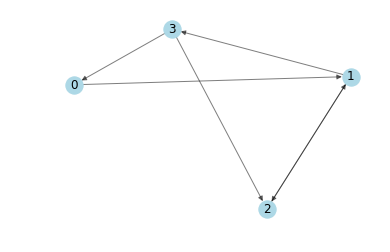

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from networkx import (
    from_numpy_matrix, DiGraph,
    draw_networkx_nodes, draw_networkx_labels, 
    draw_networkx_edges,
    spring_layout)

G = from_numpy_matrix(A, create_using=DiGraph())
pos = spring_layout(G)

draw_networkx_nodes(G, pos, node_color='lightblue')
draw_networkx_edges(G,pos,width=1.0,alpha=0.5)

labels = dict(zip(G.nodes(), G.nodes()))
draw_networkx_labels(G, pos, labels, font_size=12)
plt.axis('off')
plt.savefig('../reports/figures/simple_graph.png')

In [4]:
X = np.matrix([
    [i, -i]
    for i in range(A.shape[0])
], dtype=float)
X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])

In [5]:
I = np.matrix(np.eye(A.shape[0]))
I

matrix([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

# Naive Propagation Rule
Represents a node as the **sum** of neighboring (connected by an in edge) nodes' features.

In [6]:
A

matrix([[0., 1., 0., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [1., 0., 1., 0.]])

In [7]:
pprint(X)
A * X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])


matrix([[ 1., -1.],
        [ 5., -5.],
        [ 1., -1.],
        [ 2., -2.]])

## Add Self Loop
Equivalent to the above, but the node's own features is always included in the sum.

In [8]:
pprint(X)
A_hat = A + I
A_hat * X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])


matrix([[ 1., -1.],
        [ 6., -6.],
        [ 3., -3.],
        [ 5., -5.]])

# Normalized Propagation
Normalizes the features by node degree. Represents a node as the **mean** of neighboring (connected by an in edge) nodes' features. 

In [9]:
# Compute Degree Matrix
D = np.array(np.sum(A, axis=0))[0]
D = np.matrix(np.diag(D))
D

matrix([[1., 0., 0., 0.],
        [0., 2., 0., 0.],
        [0., 0., 2., 0.],
        [0., 0., 0., 1.]])

In [10]:
D**-1 * A

matrix([[0. , 1. , 0. , 0. ],
        [0. , 0. , 0.5, 0.5],
        [0. , 0.5, 0. , 0. ],
        [1. , 0. , 1. , 0. ]])

In [11]:
pprint(X)
D**-1 * A * X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])


matrix([[ 1. , -1. ],
        [ 2.5, -2.5],
        [ 0.5, -0.5],
        [ 2. , -2. ]])

## Add Self Loop
Equivalent to the above, but the node's own features is always included in the mean.

In [12]:
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))
D_hat

matrix([[2., 0., 0., 0.],
        [0., 3., 0., 0.],
        [0., 0., 3., 0.],
        [0., 0., 0., 2.]])

In [13]:
D_hat**-1 * A_hat

matrix([[0.5       , 0.5       , 0.        , 0.        ],
        [0.        , 0.33333333, 0.33333333, 0.33333333],
        [0.        , 0.33333333, 0.33333333, 0.        ],
        [0.5       , 0.        , 0.5       , 0.5       ]])

In [14]:
pprint(X)
D_hat**-1 * A_hat * X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])


matrix([[ 0.5, -0.5],
        [ 2. , -2. ],
        [ 1. , -1. ],
        [ 2.5, -2.5]])

# Symmetric Normalization
Represents a node as a **weighted sum** of neighboring (connected by an in edge) nodes' features. The weight of a neighbor $n$ of $v$ is $\deg(v)^{0.5} \cdot \deg(n)^{0.5}$.

In [24]:
pprint(A)
pprint(D)
power(D, -0.5)

matrix([[0., 1., 0., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [1., 0., 1., 0.]])
matrix([[1., 0., 0., 0.],
        [0., 2., 0., 0.],
        [0., 0., 2., 0.],
        [0., 0., 0., 1.]])


matrix([[1.        , 0.        , 0.        , 0.        ],
        [0.        , 0.70710678, 0.        , 0.        ],
        [0.        , 0.        , 0.70710678, 0.        ],
        [0.        , 0.        , 0.        , 1.        ]])

In [16]:
power(D, -0.5) * A # Apply weight for own degree

matrix([[0.        , 1.        , 0.        , 0.        ],
        [0.        , 0.        , 0.70710678, 0.70710678],
        [0.        , 0.70710678, 0.        , 0.        ],
        [1.        , 0.        , 1.        , 0.        ]])

In [17]:
power(D, -0.5) * A * power(D, -0.5) # Apply weight for neighbor degree

matrix([[0.        , 0.70710678, 0.        , 0.        ],
        [0.        , 0.        , 0.5       , 0.70710678],
        [0.        , 0.5       , 0.        , 0.        ],
        [1.        , 0.        , 0.70710678, 0.        ]])

In [18]:
pprint(power(D, -0.5) * A) # Apply weight for own degree
pprint(power(D, -0.5) * A * power(D, -0.5)) # Apply weight for neighbor degree

matrix([[0.        , 1.        , 0.        , 0.        ],
        [0.        , 0.        , 0.70710678, 0.70710678],
        [0.        , 0.70710678, 0.        , 0.        ],
        [1.        , 0.        , 1.        , 0.        ]])
matrix([[0.        , 0.70710678, 0.        , 0.        ],
        [0.        , 0.        , 0.5       , 0.70710678],
        [0.        , 0.5       , 0.        , 0.        ],
        [1.        , 0.        , 0.70710678, 0.        ]])


In [19]:
pprint(D**-1 * A)
pprint(power(D, -0.75) * A * power(D, -0.25)) # Importance of neighbor degree decreases
pprint(power(D, -0.25) * A * power(D, -0.75)) # Importance of neighbor degree increases
pprint(power(D, -1.0) * A * power(D, -0.0)) # Is a generalization of asymmetric normalization

matrix([[0. , 1. , 0. , 0. ],
        [0. , 0. , 0.5, 0.5],
        [0. , 0.5, 0. , 0. ],
        [1. , 0. , 1. , 0. ]])
matrix([[0.        , 0.84089642, 0.        , 0.        ],
        [0.        , 0.        , 0.5       , 0.59460356],
        [0.        , 0.5       , 0.        , 0.        ],
        [1.        , 0.        , 0.84089642, 0.        ]])
matrix([[0.        , 0.59460356, 0.        , 0.        ],
        [0.        , 0.        , 0.5       , 0.84089642],
        [0.        , 0.5       , 0.        , 0.        ],
        [1.        , 0.        , 0.59460356, 0.        ]])
matrix([[0. , 1. , 0. , 0. ],
        [0. , 0. , 0.5, 0.5],
        [0. , 0.5, 0. , 0. ],
        [1. , 0. , 1. , 0. ]])


In [20]:
pprint(X)
power(D, -0.5) * A * power(D, -0.5) * X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])


matrix([[ 0.70710678, -0.70710678],
        [ 3.12132034, -3.12132034],
        [ 0.5       , -0.5       ],
        [ 1.41421356, -1.41421356]])

##  Add Self Loops

In [21]:
power(D_hat, -0.5) * A_hat * power(D_hat, -0.5)

matrix([[0.5       , 0.40824829, 0.        , 0.        ],
        [0.        , 0.33333333, 0.33333333, 0.40824829],
        [0.        , 0.33333333, 0.33333333, 0.        ],
        [0.5       , 0.        , 0.40824829, 0.5       ]])

In [22]:
pprint(X)
power(D_hat, -0.5) * A_hat * power(D_hat, -0.5) * X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])


matrix([[ 0.40824829, -0.40824829],
        [ 2.22474487, -2.22474487],
        [ 1.        , -1.        ],
        [ 2.31649658, -2.31649658]])

In [23]:
power(D_hat, -0.5) * A_hat * power(D_hat, -0.5) * X * np.matrix([[1, -1], [0, 0]])

matrix([[ 0.40824829, -0.40824829],
        [ 2.22474487, -2.22474487],
        [ 1.        , -1.        ],
        [ 2.31649658, -2.31649658]])